In [1]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import pysal as ps

sns.set(style="whitegrid")

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'


In [3]:
# Read data
broker = pd.read_csv(broker_data)
broker.head()

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,OriginState,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
0,1361713,1349039,8/15/18,1,AMNP,AMNP,43708,43708,San Antonio,Texas,Palmyra,Wisconsin,2500,2400,100.0,4.00%,KAILA,1
1,1501026,1542730,1/30/18,1,AMNP,AMNP,442007,442007,Hammond,Indiana,Denver,Colorado,3050,2950,100.0,3.27%,KAILA,1
2,1518714,1567360,1/5/18,1,AMNP,AMNP,971955,971955,Denver,Colorado,Meridian,Idaho,1200,1200,0.0,0.00%,ZABCA,2
3,1538821,1595101,4/2/18,1,AMNP,AMNP,355478,355478,Jewett,Texas,Hartford,South Dakota,2000,1900,100.0,5.00%,KAILA,1
4,1601007,1680031,8/22/18,1,AMNP,AMNP,184749,184749,Bismarck,North Dakota,Marion,Ohio,2300,2200,100.0,4.34%,KAILA,1


In [4]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [5]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [6]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [7]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [35]:
#filter out data prior to start date to have rolling 12 months; rename origin column to state
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {'OriginState':'NAME'}, inplace = True)


for col in filteredBroker.columns:
    print(col)

filteredBroker
#Check data types to make sure margin can be integers
print(filteredBroker.dtypes)

Order #
Leg #
Start Date
Agent Office
Cust ID
Customer
Carrier ID
Carrier
Origin City
NAME
Destination City
Destination State
Brokered Revenue
Carrier Pay
Brokered Margin
Brokered Margin %
Booking Agent ID
Booking Agent
Order #                       int64
Leg #                         int64
Start Date           datetime64[ns]
Agent Office                  int64
Cust ID                      object
Customer                     object
Carrier ID                   object
Carrier                      object
Origin City                  object
NAME                         object
Destination City             object
Destination State            object
Brokered Revenue             object
Carrier Pay                  object
Brokered Margin             float64
Brokered Margin %            object
Booking Agent ID             object
Booking Agent                 int64
dtype: object


/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [36]:
# Numeric variables maintained
varis = ['Brokered Margin']

In [50]:
#Group data by state
states = filteredBroker.groupby('NAME')[varis].mean()
states

,Brokered Margin
NAME,
Alabama,300.812486
Arizona,418.143300
Arkansas,406.648622
California,449.898241
Colorado,306.973660
Connecticut,514.981145
Delaware,241.700400
Florida,313.159782
Georgia,320.951245


In [51]:
statesct = filteredBroker.groupby(['NAME']).describe().loc[:,(slice(None),['count'])]
#statesct

In [52]:
#Group by customers and convert to binary
types = pd.get_dummies(filteredBroker['Customer'])
region_types = types.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
region_types_pct.info()
region_types_pct

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alabama to Wyoming
Columns: 397 entries, 3MCFOR to ZIMLYN
dtypes: float64(397)
memory usage: 149.2+ KB


,3MCFOR,3MCSAI02,ABCBEL01,ABCNOV,ADMDEC,ADMDEC07,AESNOG,AFBU,AFPB,AFVRO,...,WWBO02,WWRO,XPOANN,XPOCHA,XPOPOR,YELCHE01,YOUCAN,ZAVSTE,ZAVSTE01,ZIMLYN
NAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Arizona,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.976285,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.592885,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Arkansas,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
California,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168776,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.084388,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Colorado,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Connecticut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Delaware,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.994514,0.000000,0.129074,0.05647,0.000000
Florida,0.000000,0.000000,0.000000,0.042662,0.000000,0.000000,0.213311,0.000000,0.213311,2.474403,...,0.042662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Georgia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264901,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.132450,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [53]:
# Combine data sets
region_props = pd.merge(states, region_types, on=["NAME"])

In [54]:
#Scale not applicable because only 1 numeric variable
#db = pd.DataFrame(\
 #                scale(region_props), \
  #               index=region_props.index, \
   #              columns=region_props.columns)\
    #   .rename(lambda x: str(int(x)))
db = region_props

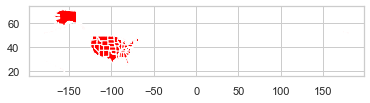

In [55]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [56]:
# match geojson dataframe and broker_data on 'state'
statedb = usMap[['geometry', 'STATE', 'NAME']].join(db, on='NAME')\
                                         .dropna()

In [57]:
#Optimal Cluster Calculations
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    #km.fit(X)
    km = km.fit(statesct) #count of Origin state
    Sum_of_squared_distances.append(km.inertia_)

In [58]:
Sum_of_squared_distances

[1351964189.8958328,
 302673937.33333325,
 132534766.49211712,
 66259163.158783786,
 24764002.950450454,
 7213420.424242424,
 4991970.007575759,
 3470863.461538462,
 2257830.138888889]

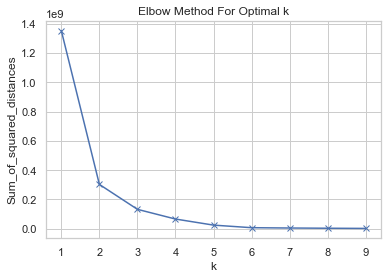

In [59]:
#optimal clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [66]:
#Cluster in specfic groups
cluster_count = 5
km5 = cluster.KMeans(n_clusters=cluster_count)

In [67]:
# Fit to data
km5cls = km5.fit(statedb.drop(['geometry', 'NAME'], axis=1).values)

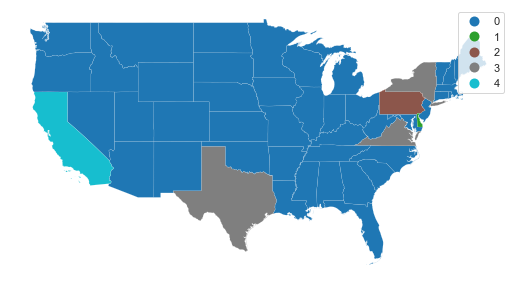

In [68]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

statedb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

Regions = plt.show()
Regions

In [24]:
#Bind to html
result = Regions.to_html()
print(result)

AttributeError: 'NoneType' object has no attribute 'to_html'

In [25]:
html = Regions.to_html()
# write html to file
text_file = open("index.html", "w")
text_file.write(html)
text_file.close()

AttributeError: 'NoneType' object has no attribute 'to_html'

In [26]:
# Attributes
cl_pcts = region_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(statedb['NAME'])\
                          .assign(cl=km5cls.labels)\
                          .groupby('cl')\
                          .mean()

ValueError: invalid literal for int() with base 10: 'Alabama'

NameError: name 'cl_pcts' is not defined

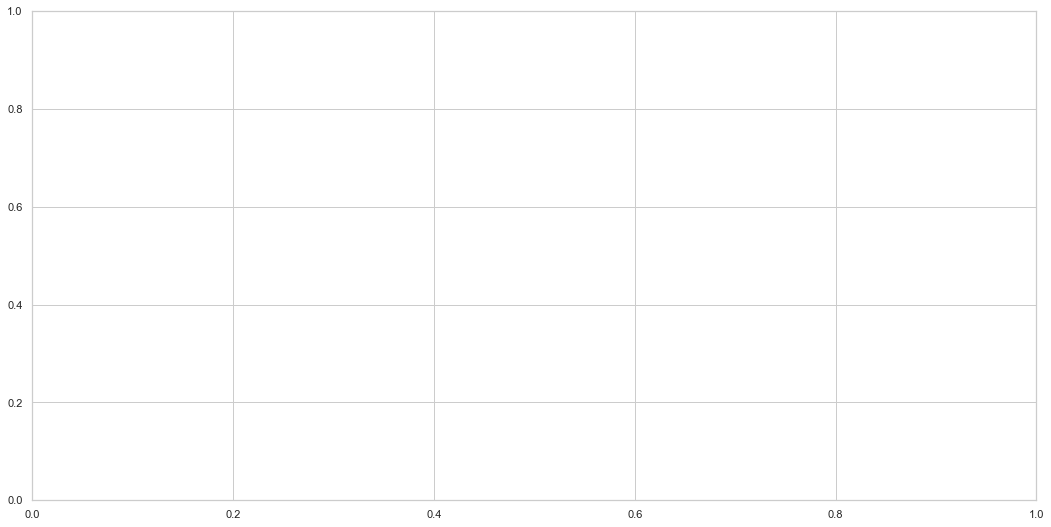

In [27]:
#Visualize attributes and mix
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");

In [69]:
# Add layer to balance load volume and remove enterprise accounts
loads = filteredBroker.groupby('NAME').count()
loads = loads['Order #']
loads

NAME
Alabama             185
Arizona             506
Arkansas            283
California         4740
Colorado           1019
Connecticut         943
Delaware          12396
Florida            2344
Georgia             755
Idaho               105
Illinois           2203
Indiana             734
Iowa                878
Kansas              735
Kentucky            199
Louisiana           919
Maine               192
Maryland            480
Massachusetts        88
Michigan            273
Minnesota           773
Mississippi          19
Missouri            304
Montana               1
Nebraska             14
Nevada               54
New Hampshire        39
New Jersey         1736
New Mexico           97
New York           8214
North Carolina     2303
North Dakota        112
Ohio                809
Oklahoma            193
Oregon              805
Pennsylvania       7660
Rhode Island        178
South Carolina      489
South Dakota         40
Tennessee           647
Texas              4099
Utah       

In [70]:
#Link to state geometries
statedb_bal = usMap[['geometry', 'STATE', 'NAME']].join(loads, on='NAME')\
                                         .dropna()

statedb_bal.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 48 entries, 0 to 51
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  48 non-null     geometry
 1   STATE     48 non-null     object  
 2   NAME      48 non-null     object  
 3   Order #   48 non-null     float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.9+ KB


In [72]:
#Apply weights
statedb_bal.to_file('tmp')
w = ps.queen_from_shapefile('tmp/tmp.shp', idVariable='NAME')
! rm -r tmp
w

AttributeError: module 'pysal' has no attribute 'queen_from_shapefile'

In [73]:
#Regionalization needs to have column header added to loads count, set threshold for max amount of volume allowed
n_loads = lst.groupby('NAME')\
           .sum()\
           ['loads']\
           .rename(lambda x: str(int(x)))\
           .reindex(statedb_bal['NAME'])
thr = np.round(0.1 * n_loads.sum())
thr

NameError: name 'lst' is not defined

In [74]:
# Set the seed for reproducibility
np.random.seed(1234)

z = statedb_bal.drop(['geometry', 'NAME'], axis=1).values
maxp = ps.region.Maxp(w, z, thr, n_loads.values[:, None], initial=1000)

AttributeError: module 'pysal' has no attribute 'region'

In [75]:
#  Calculate P value to determine effectiveness %%time
np.random.seed(1234)
maxp.cinference(nperm=999)
maxp.cpvalue

NameError: name 'maxp' is not defined

In [76]:
# Extract labels
lbls = pd.Series(maxp.area2region).reindex(statedb_bal['NAME'])

NameError: name 'maxp' is not defined

NameError: name 'lbls' is not defined

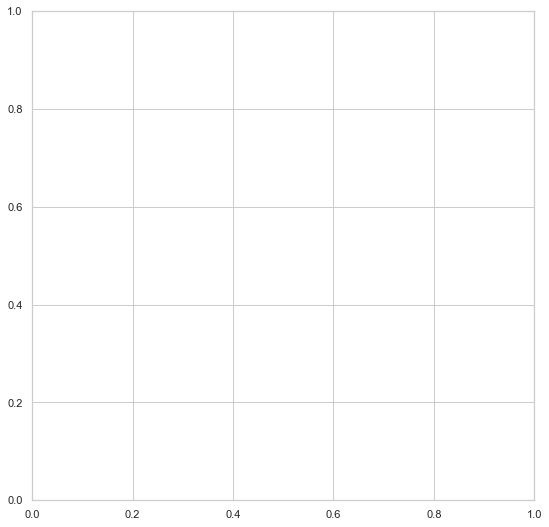

In [77]:
#Map
f, ax = plt.subplots(1, figsize=(9, 9))

statedb_bal.assign(cl=lbls.values)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [ ]:
#Categorical Data of loads
statedb[loads].groupby(lbls.values).mean().T